In [140]:
import pandas as pd

with open('pklDat.pkl', 'rb') as file:
    data = pd.read_pickle(file)

final_df = data['final_df']
trait_dict = data['trait_dict']

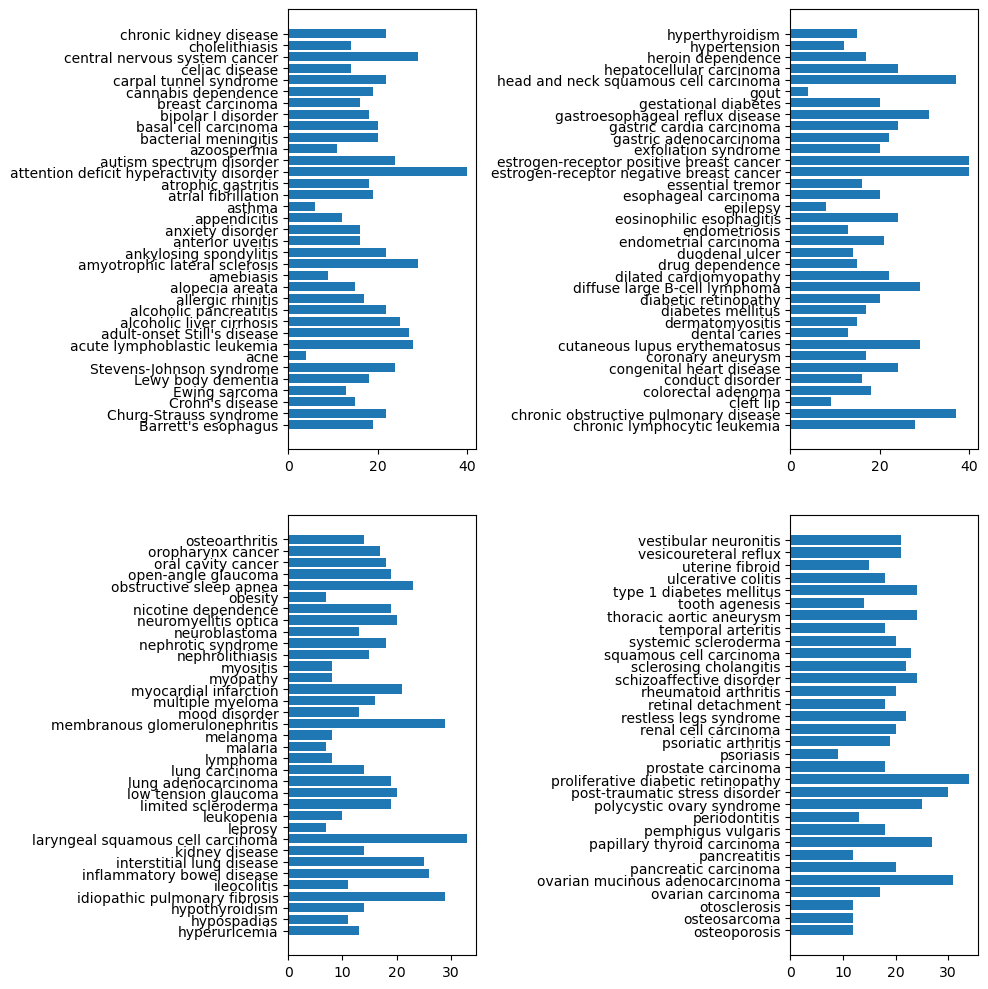

In [141]:
import matplotlib.pyplot as plt
from more_itertools import chunked

count_dict = {x:len(x)for x in trait_dict}

traits = list(count_dict.keys())
count = list(count_dict.values())

t_chunk = list(chunked(traits,(len(traits)//4)+1))
c_chunk =  list(chunked(count,(len(count)//4)+1))

plt.figure(figsize=(10, 10))

plt.subplot(2,2,1,)
plt.barh(t_chunk[0],c_chunk[0])

plt.subplot(2,2,2)
plt.barh(t_chunk[1],c_chunk[1])

plt.subplot(2,2,3)
plt.barh(t_chunk[2],c_chunk[2])

plt.subplot(2,2,4)
plt.barh(t_chunk[3],c_chunk[3])

plt.tight_layout(h_pad=3)




Text(0.5, 1.0, 'cutaneous lupus erythematosus')

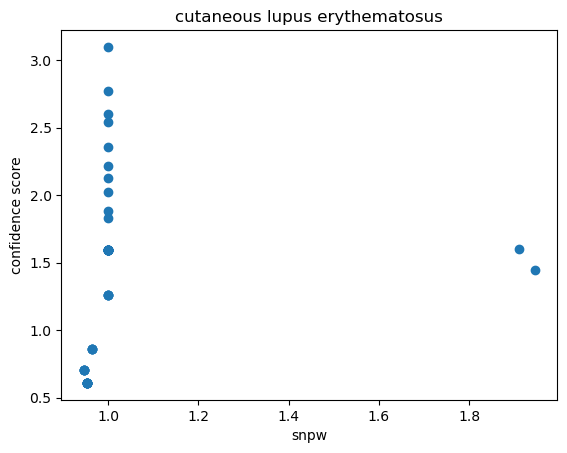

In [149]:
import random

diseases = list(trait_dict.keys())
selected = diseases[random.randint(0,len(diseases)-1)]
data = trait_dict[selected]
snpw = data['n_snpw']
conf_score = data['integrated_confidenceScore']
# exp_conf_score = data['confidenceScore']

plt.scatter(snpw,conf_score)
plt.xlabel('snpw')
plt.ylabel('confidence score')
plt.title(selected)

